<a href="https://colab.research.google.com/github/AndrzejOlejniczak/AndrzejOlejniczak/blob/main/Quickie_03_Decision_Tree_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Regressor from Scratch:
## Airfoil Self Noise Data

## Prepare environment

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Get the data

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Airfoil Self Noise data/AirfoilSelfNoise.csv'

In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/Airfoil Self Noise data')

['AirfoilSelfNoise.csv']

In [ ]:
airfoil_data = pd.read_csv(data_dir)

In [ ]:
airfoil_data.head()

,f,alpha,c,U_infinity,delta,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


## Inspect the data

Attribute Information (from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/airfoil-selfnoise-dataset/code)):

Input features:

    f: Frequency in Hertzs [Hz].
    alpha: Angle of attack (AoA, α), in degrees [°].
    c: Chord length, in meters [m].
    U_infinity: Free-stream velocity, in meters per second [m/s].
    delta: Suction side displacement thickness (𝛿), in meters [m].

Output:

    SSPL: Scaled sound pressure level, in decibels [dB].


In [ ]:
airfoil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   f           1503 non-null   int64  
 1   alpha       1503 non-null   float64
 2   c           1503 non-null   float64
 3   U_infinity  1503 non-null   float64
 4   delta       1503 non-null   float64
 5   SSPL        1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [ ]:
airfoil_data.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [ ]:
airfoil_corr = airfoil_data.corr()
print(airfoil_corr)

                   f     alpha         c  U_infinity     delta      SSPL
f           1.000000 -0.272765 -0.003661    0.133664 -0.230107 -0.390711
alpha      -0.272765  1.000000 -0.504868    0.058760  0.753394 -0.156108
c          -0.003661 -0.504868  1.000000    0.003787 -0.220842 -0.236162
U_infinity  0.133664  0.058760  0.003787    1.000000 -0.003974  0.125103
delta      -0.230107  0.753394 -0.220842   -0.003974  1.000000 -0.312670
SSPL       -0.390711 -0.156108 -0.236162    0.125103 -0.312670  1.000000


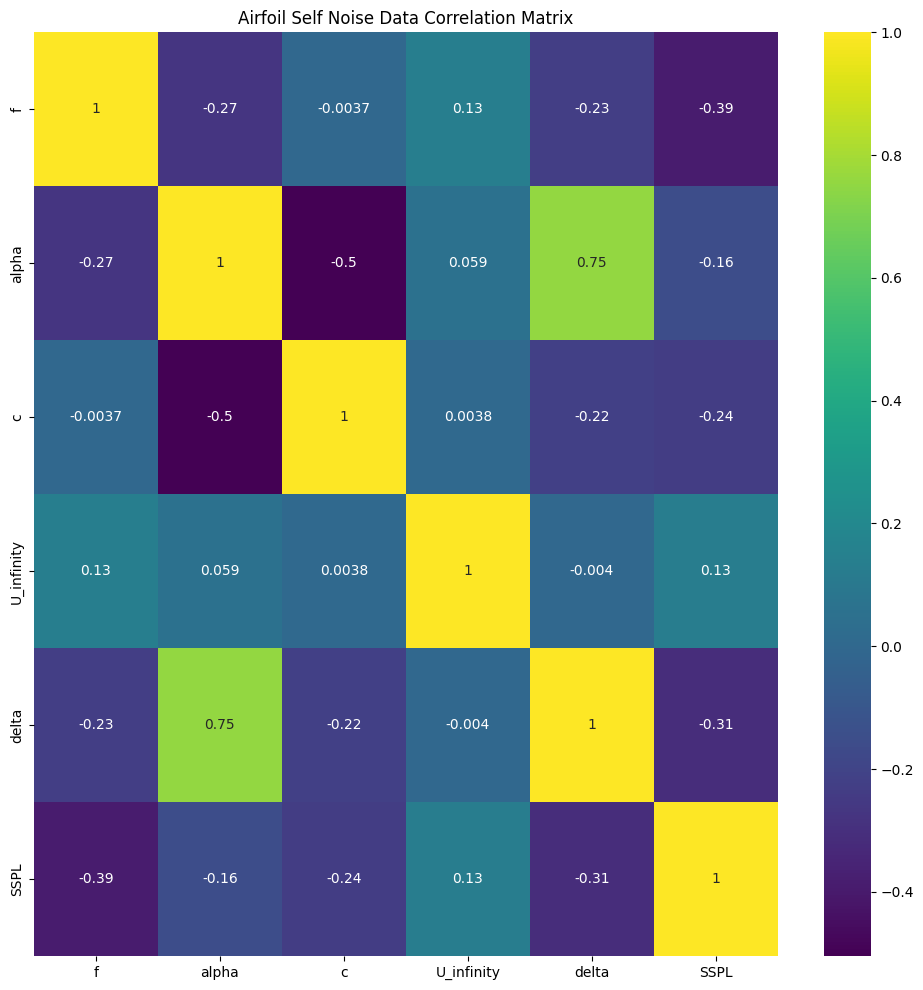

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(airfoil_corr, cmap='viridis', annot=True, ax=ax)
plt.title('Airfoil Self Noise Data Correlation Matrix')
plt.show()

In [ ]:
np.shape(airfoil_data.values[:, :-1])

(1503, 5)

## Create the model

### Node class

In [ ]:
class Node():
  def __init__(
      self,
      feature_index=None,
      threshold=None,
      left=None,
      right=None,
      var_red=None,
      value=None
    ):
    self.feature_index = feature_index
    self.threshold = threshold
    self.left = left
    self.right = right
    self.var_red = var_red
    self.value = value

### Tree class

In [ ]:
from numpy.core.multiarray import concatenate
class DecisionTreeRegressor():
  def __init__(self, min_samples_split=2, max_depth=2):
    self.root = None # starting point
    self.min_samples_split = min_samples_split # stopping criterion: are there enough samples to split into branches?
    self.max_depth =  max_depth # stopping criterion: how deep goes the tree?

  def build_tree(self, dataset, curr_depth=0):
    X, Y = dataset[:, :-1], dataset[:, -1]
    num_samples, num_features = np.shape(X)
    best_split = {} # @! Why is it here and also in get_best_split function???
    if num_samples >= self.min_samples_split and curr_depth <= self.max_depth: # stopping criteria check
      best_split = self.get_best_split(dataset, num_samples, num_features)
      if best_split['var_red'] > 0: # if variance reduction > 0 -> split the data into subtrees
        left_subtree = self.build_tree(best_split['dataset_left'], curr_depth+1)
        right_subtree = self.build_tree(best_split['dataset_right'], curr_depth+1)

        return Node(
            best_split['feature_index'],
            best_split['threshold'],
            left_subtree,
            right_subtree,
            best_split['var_red']) # Create a decision Node and stop the function

    leaf_value = self.calculate_leaf_value(Y)
    return Node(value=leaf_value) # if stopping criterions are met OR variance reduction is not > 0 -> create a leaf and end recursion

  def variance_reduction(self, parent, l_child, r_child): # splitting criterion
    weight_l = len(l_child) / len(parent)
    weight_r = len(l_child) / len(parent)
    reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
    return reduction

  def calculate_leaf_value(self, Y):
    val = np.mean(Y)
    return val

  def split(self, dataset, feature_index, threshold): # split the dataset
    dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
    dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
    return dataset_left, dataset_right

  def get_best_split(self, dataset, num_samples, num_features):
    best_split = {}
    max_var_red = -float('inf')

    # Iterate through features to find best feature candidate for split
    for feature_index in range(num_features):
      feature_values = dataset[:, feature_index]
      possible_thresholds = np.unique(feature_values)

      # iterate through feature values to find best value candidate for split
      for threshold in possible_thresholds:
        dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
        if len(dataset_left) > 0 and len(dataset_right) > 0:
          y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
          curr_var_red = self.variance_reduction(y, left_y, right_y)
          if curr_var_red > max_var_red:
            best_split['feature_index'] = feature_index
            best_split['threshold'] = threshold
            best_split['dataset_left'] = dataset_left
            best_split['dataset_right'] = dataset_right
            best_split['var_red'] = curr_var_red
            max_var_red = curr_var_red

    return best_split

  def print_tree(self, tree = None, indent = ' '):
    if not tree:
      tree = self.root

    if tree.value is not None:
      print(tree.value)

    else:
      print('X_' + str(tree.feature_index), '<=', tree.threshold, '?', tree.var_red)
      print('%sleft:' % (indent), end='')
      self.print_tree(tree.left, indent + indent)
      print('%sright' % (indent), end='')
      self.print_tree(tree.right, indent + indent)

  def fit(self, X, Y):
    dataset = np.concatenate((X, Y), axis=1)
    self.root = self.build_tree(dataset)

  def make_prediction(self, x, tree):
    if tree.value !=None: return tree.value

    # Select a feature to split on in this particular node
    feature_val = x[tree.feature_index]
    if feature_val <= tree.threshold:
      return self.make_prediction(x, tree.left)
    else:
      return self.make_prediction(x, tree.right)

  def predict(self, X):
    predictions = [self.make_prediction(x, self.root) for x in X]
    return predictions


## Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_data = airfoil_data.iloc[:, :-1].values
y_data = airfoil_data.iloc[:, -1].values.reshape(-1,1)

print(X_data[:10], type(X_data), X_data.dtype)
print(y_data[:10], type(y_data), y_data.dtype)

[[8.00000e+02 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [1.00000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [1.25000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [1.60000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [2.00000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [2.50000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [3.15000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [4.00000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [5.00000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [6.30000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]] <class 'numpy.ndarray'> float64
[[126.201]
 [125.201]
 [125.951]
 [127.591]
 [127.461]
 [125.571]
 [125.201]
 [123.061]
 [121.301]
 [119.541]] <class 'numpy.ndarray'> float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=44)

## Fit the model

In [ ]:
regressor_obj = DecisionTreeRegressor(min_samples_split=3, max_depth=3)

In [ ]:
regressor_obj.fit(X_train, y_train)

In [ ]:
regressor_obj.print_tree()

X_4 <= 0.000400682 ? 46.75639223326483
 left:X_0 <= 2500.0 ? 7.065230484693869
  left:133.707
  rightX_0 <= 3150.0 ? 7.960202947845798
    left:137.007
    rightX_0 <= 4000.0 ? 8.52442888888887
        left:138.557
        right133.137
 rightX_4 <= 0.00041229 ? 46.20990035122228
  left:X_0 <= 2000.0 ? 17.25820208641975
    left:127.623
    rightX_0 <= 2500.0 ? 17.71724969135802
        left:130.073
        right131.203
  rightX_4 <= 0.000428464 ? 46.0884300813114
    left:X_0 <= 1600.0 ? 16.67962106611569
        left:124.156
        right132.71900000000002
    rightX_4 <= 0.000439472 ? 46.08619270151364
        left:132.86557142857143
        right124.5444459691252


## Evaluate the model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
y_pred = regressor_obj.predict(X_test)

In [ ]:
print(mean_squared_error(y_test, y_pred))

48.33460123215295


In [ ]:
print(mean_absolute_error(y_test, y_pred))

5.6531972669717305


In [ ]:
airfoil_data.SSPL.describe()

count    1503.000000
mean      124.835943
std         6.898657
min       103.380000
25%       120.191000
50%       125.721000
75%       129.995500
max       140.987000
Name: SSPL, dtype: float64